In [1]:
import os
from dotenv import load_dotenv; load_dotenv()

from tqdm.notebook import tqdm
import pickle
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"
import torch
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.preprocessing import normalize

from src.helpers import preprocessing as preproc
from src.helpers import postprocessing as postproc
from src.helpers.postprocessing import from_list_to_string
from src.helpers.sentiment_analysis import SentimentModel
from src.topol_modeling import TopolModeling as TOPOL
from src.openai_api import OPENAI_CLIENT, OpenAIEmbedding
from src.openai_api import chat_completion as openai_chat_completion
from src.google_ai_api import GGENAI_CLIENT, GoogleAIEmbedding, AdvancedGoogleAIEmbedding
from src.google_ai_api import chat_completion as google_chat_completion

In [2]:
DATA_PATH = os.getenv("DATA_PATH")
OUTPUTS_PATH = os.getenv("OUTPUTS_PATH")

DEVICE = torch.device("mps")
STOP_WORDS = list(ENGLISH_STOP_WORDS)
RANDOM_STATE = 42

# Getting data

In [3]:
df = pd.read_pickle(os.path.join(DATA_PATH, "us_fed_speeches.pickle"))
FILES_PREFIX = "us_speeches"

In [4]:
# breakpoint = pd.to_datetime("2007-05-01")

# df["label"] = 1.0
# df.loc[df["date"] <= breakpoint, "label"] = 0

# Pre-processing data

##### 1. Data cleaning

In [5]:
entities_to_mask = ["DATE", "TIME", "ORGANIZATION", "NUM", "LOCATION"]
STOP_WORDS += entities_to_mask

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_texts.pickle")
if os.path.exists(fpath):
    print(f"Loading cleaned texts from {fpath}")
    with open(fpath, "rb") as f:
        texts = pickle.load(f)
    print(f"Loaded {len(texts)} texts")
else:
    print(f"Generating cleaned texts for {len(df)} raw texts...")
    texts = []
    for i, row in tqdm(df.iterrows(), total=len(df)):
        cleaned_text = preproc.get_clean_text(row, entities_to_mask=entities_to_mask, max_lenght=5000)
        texts.append(cleaned_text)
    with open(fpath, "wb") as f:
        pickle.dump(texts, f)
    print(f"Saved {len(texts)} cleaned texts to {fpath}.")

df["text"] = texts
del fpath

Loading cleaned texts from /Users/tig1/Programming/TOPOL/data/us_speeches_texts.pickle
Loaded 600 texts


##### 2. Embedding texts

In [6]:
EMBEDDING_MODEL = OpenAIEmbedding(model="text-embedding-3-small")
# EMBEDDING_MODEL = GoogleAIEmbedding(model="text-embedding-004")
# EMBEDDING_MODEL = AdvancedGoogleAIEmbedding(model='text-embedding-004', task='clustering')
# EMBEDDING_MODEL = SentenceTransformer('intfloat/multilingual-e5-large-instruct', device=DEVICE)

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_embeddings.pickle")
if os.path.exists(fpath):
    print(f"Loading embeddings from {fpath}")
    with open(fpath, "rb") as f:
        embeddings = pickle.load(f)
    print(f"Loaded {len(embeddings)} embeddings")
else:
    print(f"Generating embeddings for {len(df)} text...")
    embeddings = EMBEDDING_MODEL.encode(df["text"].tolist(), fast=False)
    with open(fpath, "wb") as f:
        pickle.dump(embeddings, f)
    print(f"Saved {len(embeddings)} embeddings to {fpath}.")

df["embedding"] = embeddings.tolist()
del fpath

Loading embeddings from /Users/tig1/Programming/TOPOL/data/us_speeches_embeddings.pickle
Loaded 600 embeddings


##### 3. Sentiment Analysis

In [7]:
sentiment_model = SentimentModel(model_name="ProsusAI/finbert", device=DEVICE, n_special_tokens=5)

fpath = os.path.join(DATA_PATH, f"{FILES_PREFIX}_sentiments.pickle")
if os.path.exists(fpath):
    print(f"Loading sentiments from {fpath}")
    with open(fpath, "rb") as f:
        sentiments = pickle.load(f)
    print(f"Loaded {len(sentiments)} sentiments")
else:
    print(f"Generating sentiments for {len(df)} texts...")
    sentiments = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        doc = row['text']
        temp_sentiment = sentiment_model(doc, truncation=False)
        sentiments.append(temp_sentiment)
    with open(fpath, "wb") as f:
        pickle.dump(sentiments, f)
    print(f"Saved {len(sentiments)} sentiments to {fpath}.")

df["sentiment"] = sentiments
df["sentiment_score"] = df["sentiment"].apply(sentiment_model.get_sentiment_score)
del fpath

Device set to use mps


Loading sentiments from /Users/tig1/Programming/TOPOL/data/us_speeches_sentiments.pickle
Loaded 600 sentiments


# TOPOL Modeling

### Prepare data

In [8]:
data_A = df[df["label"] == 1].copy()
data_B = df[df["label"] == 0].copy()

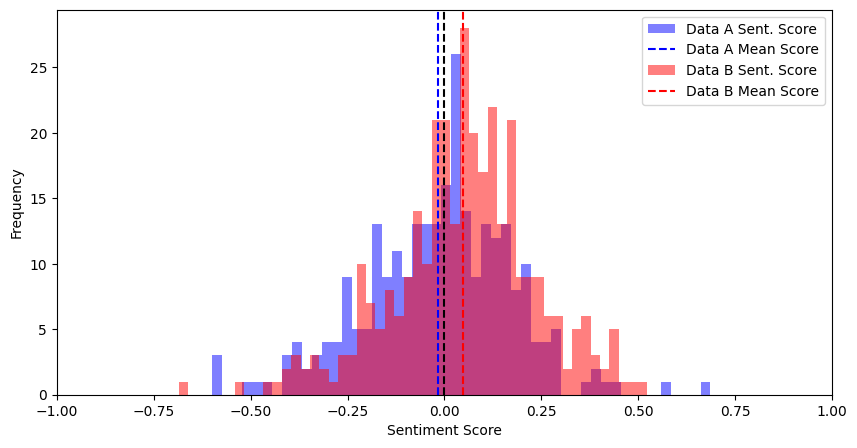

In [9]:
plt.figure(figsize=(10, 5))
plt.hist(data_A["sentiment_score"].values, bins=50, alpha=0.5, label='Data A Sent. Score', color='blue')
plt.axvline(x=data_A["sentiment_score"].mean(), color='blue', linestyle='--', label='Data A Mean Score')
plt.hist(data_B["sentiment_score"].values, bins=50, alpha=0.5, label='Data B Sent. Score', color='red')
plt.axvline(x=data_B["sentiment_score"].mean(), color='red', linestyle='--', label='Data B Mean Score')
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.xlim(-1, 1)
plt.legend()
plt.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_sentiment_score_histogram.png"))
plt.show()

### Prepare UMAP, Leiden and vectorizer model

In [28]:
umap_params = {
    'n_neighbors': 200,
    'min_dist': 0.0,
    'metric': 'cosine',
    'transform_mode': "embedding",
    'random_state': RANDOM_STATE
}

leiden_params = {
    'resolution': 2.0,
    'modularity': 'dugue',
    'random_state': RANDOM_STATE,
}

vectorizer_model = CountVectorizer(stop_words=STOP_WORDS, ngram_range=(1, 2), max_features=10000)

topol_model = TOPOL(
    n_components=100,
    umap_model_params=umap_params,
    leiden_model_params=leiden_params,
    vectorizer_model=vectorizer_model,
    supervised=False,
)

In [29]:
topol_model.umap_model.random_state

42

### TOPOL modeling analysis

In [30]:
topol_model.apply_modeling(
    df_A=data_A,
    df_B=data_B,
    n_top_freq_words=20,
    n_repr_docs=10,
    n_top_tf_idf_words=20
)

/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be r

UMAP applied successfully.
Leiden clustering applied successfully.


/Users/tig1/miniforge3/envs/topol/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['date', 'location', 'num', 'organization', 'time'] not in stop_words.
  warnings.warn(


Cluster information extracted successfully.


In [31]:
topol_model.dataset_A.cluster_info

Cluster  Count                                          Top_Words  \
0         0     28  {'date': 1579, 'num': 848, 'inflation': 790, '...   
1         1     26  {'date': 1671, 'inflation': 1313, 'num': 1227,...   
2         2     10  {'date': 529, 'num': 352, 'economies': 211, 'f...   
3         3      7  {'risk': 402, 'management': 217, 'basel': 202,...   
4         4     41  {'financial': 1784, 'federal': 726, 'risk': 67...   
5         5     30  {'date': 938, 'mortgage': 733, 'num': 657, 'fe...   
6         6     30  {'date': 1125, 'federal': 1124, 'reserve': 965...   
7         7     27  {'financial': 1051, 'date': 827, 'market': 696...   
8         8     14  {'date': 792, 'num': 485, 'credit': 466, 'bank...   
9         9      5  {'risk': 181, 'financial': 168, 'market': 158,...   
10       10     15  {'financial': 229, 'date': 225, 'federal': 218...   
11       11      4  {'date': 225, 'education': 92, 'num': 89, 'sch...   
12       12     11  {'date': 460, 'financial': 410, 'policy': 294,...   
13       13     16  {'financial': 520, 'date': 423, 'federal': 285...   
14       14      2  {'health': 97, 'care': 73, 'date': 68, 'num': ...   
15       15      1  {'payments': 84, 'date': 43, 'check': 34, 'res...   

                                             Centroid  \
0   [0.003946028481420528, 0.013823826107129986, 0...   
1   [-0.004368760845234367, 0.0007884696242399514,...   
2   [-0.008198037231341004, 0.016083620372228324, ...   
3   [0.01343620355640139, 0.032394512955631526, 0....   
4   [0.003930101446557518, 0.013894789483080186, 0...   
5   [0.018876637165279438, 0.03117025933849315, 0....   
6   [-0.014458017863701874, 0.009307685506064445, ...   
7   [0.008137686518710796, 0.026121264978967332, 0...   
8   [0.002059268033398049, 0.013133777372006859, 0...   
9   [0.007674471475183964, 0.014745112555101515, 0...   
10  [0.00098760809438924, -0.002939456794410944, 0...   
11  [0.030949509236961603, -0.020231669070199132, ...   
12  [-0.0040934616911479016, 0.024562684988433666,...   
13  [0.009762166941072792, 0.005080190221633529, 0...   
14  [0.01604400167707354, 0.0036333093157736585, 0...   
15  [-0.00020456624042708427, -0.01152358390390873...   

                                  2D_Centroid  \
0   [-11.333815744944982, -5.100133095468793]   
1   [-10.484849416292631, -5.583132615456214]   
2    [-11.074764919281005, -4.94983983039856]   
3   [-7.554422514779227, -3.7268153599330356]   
4   [-7.3694101194056065, -3.912773196290179]   
5     [-9.5232341448466, -2.7438161849975584]   
6    [-9.848190975189208, -4.507636324564616]   
7     [-8.80857315769902, -2.874107343179208]   
8   [-9.515381813049316, -3.9182872431618825]   
9   [-7.997323036193848, -3.2716842174530028]   
10    [-8.89617525736491, -5.217146110534668]   
11     [-9.626172065734863, -5.4847092628479]   
12   [-9.473734335465865, -4.421949451619929]   
13   [-8.807166337966919, -3.930978164076805]   
14  [-10.729796886444092, -5.027101039886475]   
15   [-8.062724113464355, -3.757194995880127]   

                              Top_Representative_Docs  \
0   [Ben S Bernanke: The economic outlook Testimon...   
1   [Donald L Kohn: Monetary policy research and t...   
2   [Donald L Kohn: Global economic integration an...   
3   [Randall S Kroszner: The importance of fundame...   
4   [Ben S Bernanke: Financial regulation and supe...   
5   [Randall S Kroszner: Loan modifications and fo...   
6   [Ben S Bernanke: Federal Reserve policies to e...   
7   [Frederic S Mishkin: Global financial turmoil ...   
8   [Daniel K Tarullo: State of the banking indust...   
9   [Donald L Kohn: Financial stability and policy...   
10  [Ben S Bernanke: Confirmation hearing Testimon...   
11  [Ben S Bernanke: Recognizing leadership Remark...   
12  [Donald L Kohn: Financial markets and central ...   
13  [Ben S Bernanke: US financial markets Testimon...   
14  [Thomas M Hoenig: Knocking on the central bank...   
15  [Randall S Kroszner: The future of payment

In [32]:
topol_model.dataset_B.cluster_info

Cluster  Count                                          Top_Words  \
0         0     48  {'date': 2844, 'num': 1336, 'inflation': 920, ...   
1         1     42  {'date': 1970, 'inflation': 1744, 'policy': 12...   
2         2     46  {'date': 1941, 'num': 1488, 'trade': 834, 'fin...   
3         3     48  {'risk': 2263, 'basel': 1487, 'management': 11...   
4         4     11  {'date': 359, 'financial': 334, 'federal': 276...   
5         5     12  {'date': 379, 'data': 279, 'num': 239, 'commun...   
6         6      3  {'date': 135, 'reserve': 134, 'federal': 111, ...   
7         7      1  {'financial': 69, 'market': 60, 'risk': 39, 'c...   
8         8     13  {'date': 593, 'banks': 573, 'banking': 325, 'n...   
9         9     22  {'risk': 816, 'financial': 788, 'market': 492,...   
10       10     11  {'date': 189, 'financial': 146, 'federal': 108...   
11       11     20  {'date': 1005, 'productivity': 531, 'num': 430...   
12       12     12  {'date': 412, 'prices': 381, 'asset': 358, 'ri...   
13       13      4  {'mortgage': 187, 'gses': 170, 'gse': 159, 'nu...   
14       14     12  {'date': 499, 'num': 377, 'budget': 218, 'futu...   
15       15     11  {'reserve': 447, 'banks': 392, 'date': 370, 'f...   
16       16     10  {'date': 669, 'debt': 290, 'num': 277, 'financ...   
17       17      7  {'oil': 561, 'date': 407, 'prices': 351, 'ener...   

                                             Centroid  \
0   [0.011174943522443451, 0.02048006247059675, 0....   
1   [-0.0024915513516004595, 4.374326644687071e-05...   
2   [0.01115461302232807, 0.017622098842959687, 0....   
3   [0.021525877943380085, 0.026192345127734978, 0...   
4   [-0.002713182560083541, 0.007088622332296588, ...   
5   [0.030697118820777785, 0.013753806969968233, 0...   
6   [-0.02195293704668681, 0.009344532154500484, 0...   
7   [-0.03544478490948677, 0.019126521423459053, 0...   
8   [0.021702544656223975, 0.02017965608348067, 0....   
9   [0.008167588072617284, 0.019361019018106163, 0...   
10  [0.00011769912882962011, -0.013478567047886, 0...   
11  [0.0236498364363797, 0.016090854711364955, 0.0...   
12  [0.0005311873974278569, 0.01045464427556908, 0...   
13  [0.04183197021484375, 0.01807922264561057, 0.0...   
14  [0.024655478618418176, 0.00741942270421229, 0....   
15  [0.005604118976572698, 0.00792839132588018, 0....   
16  [0.029503946751356126, 0.02133836499415338, 0....   
17  [-0.039162452199629376, 0.006361149850168398, ...   

                                   2D_Centroid  \
0    [-11.955133974552155, -4.946571975946426]   
1    [-10.623340629395985, -5.758262889725821]   
2    [-11.294243273527727, -4.334904074668884]   
3    [-6.989895323912303, -3.7968111783266068]   
4     [-7.594332955100319, -4.537316452373158]   
5    [-9.843790451685587, -2.9153256118297577]   
6     [-8.499431451161703, -5.949731985727946]   
7     [-7.821559429168701, -2.279682159423828]   
8      [-8.76024209536039, -4.093943614226121]   
9     [-7.54714280908758, -2.9273438941348684]   
10    [-8.727733872153543, -5.378142356872559]   
11   [-10.964002466201782, -4.582267463207245]   
12   [-10.12405792872111, -4.6357704401016235]   
13    [-8.311415791511536, -1.917912095785141]   
14  [-11.437750498453775, -4.3351103862126665]   
15    [-8.500080412084406, -5.228988907553933]   
16   [-11.09466061592102, -3.5336647987365724]   
17   [-11.675983428955078, -4.274427516119821]   

                              Top_Representative_Docs  \
0   [Mark W Olson: Update on the US economy Remark...   
1   [Alan Greenspan: Jackson Hole Conference - ref...   
2   [Alan Greenspan: Euro in wider circles Remarks...   
3   [Susan Schmidt Bies: A US supervisor's perspec...   
4   [Ben S Bernanke: Bank regulation and supervisi...   
5   [Ben S Bernanke: Community development financi...   
6   [Ben S Bernanke: Implementing monetary policy ...   
7   [Donald L Kohn: The evolving nature of the fin...   
8   [Alan Greenspan: Banking Remarks by Mr Alan Gr...   
9   [Timoth

Drift computed successfully, ready to vizualize.


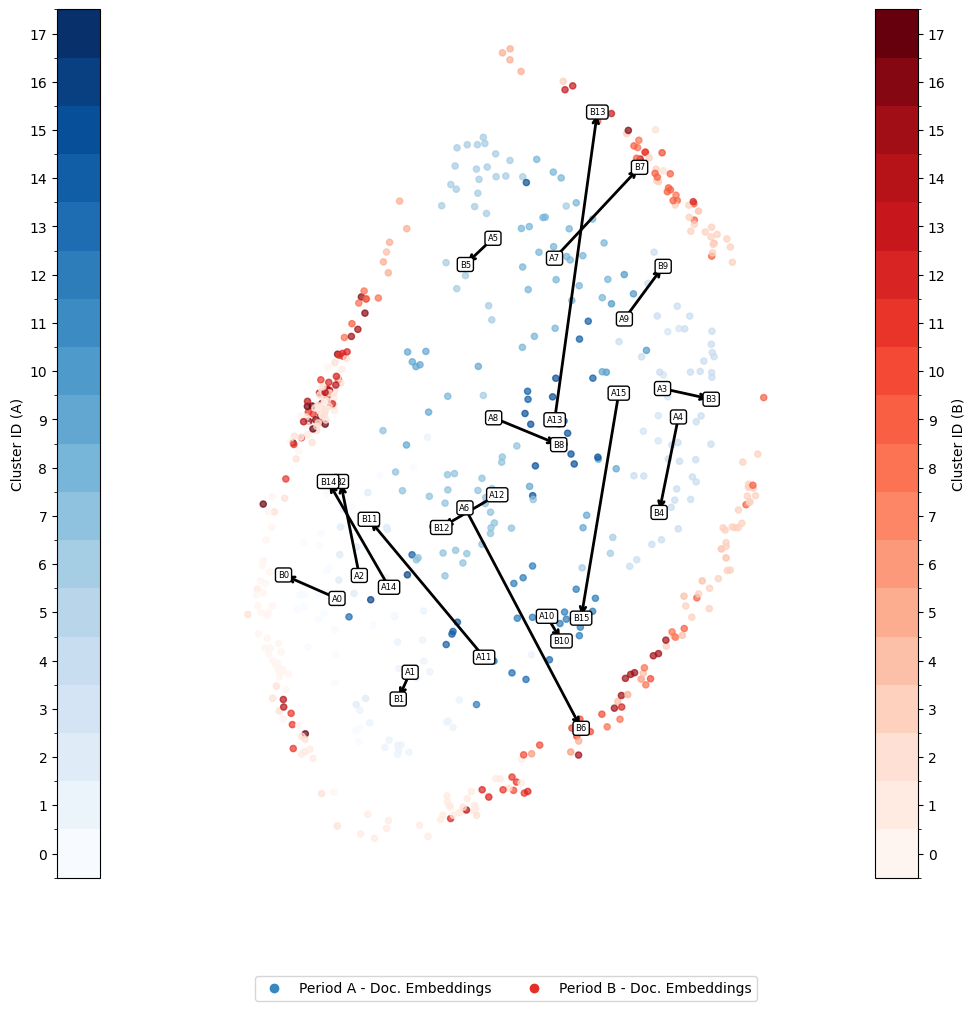

In [33]:
fig, ax = topol_model.vizualize_clusters()
fig.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_topol_clusters.pdf"), format="pdf", bbox_inches='tight')
plt.show(fig, ax)

### Drift analysis

In [34]:
no_nan_drifts = { k: v for k, v in topol_model.drifts.items() if isinstance(v, np.ndarray) }
drifts_df = pd.DataFrame.from_dict(no_nan_drifts, orient='index', columns=['x', 'y'])
# drifts_df = pd.DataFrame.from_dict(topol_model.drifts, orient='index', columns=['x', 'y']).dropna()
drifts_df.index.name = "Cluster"

In [35]:
# Normalize drift vectors to unit length
unit_drifts = normalize(drifts_df.dropna().values, norm='l2')

k = 4
# # KMeans on unit vectors ≈ angular k-means (cosine similarity)
# kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
# drifts_df["labels"] = kmeans.fit_predict(unit_drifts)

# Compute angles in radians
angles = np.arctan2(unit_drifts[:, 1], unit_drifts[:, 0])   # range [-pi, pi]
angles = (angles + 2 * np.pi) % (2 * np.pi)                 # convert to [0, 2pi]
sector_size = 2 * np.pi / k                                 # Define number of angular sectors
labels = np.floor(angles / sector_size).astype(int)         # Assign each angle to a sector
drifts_df["labels"] = labels

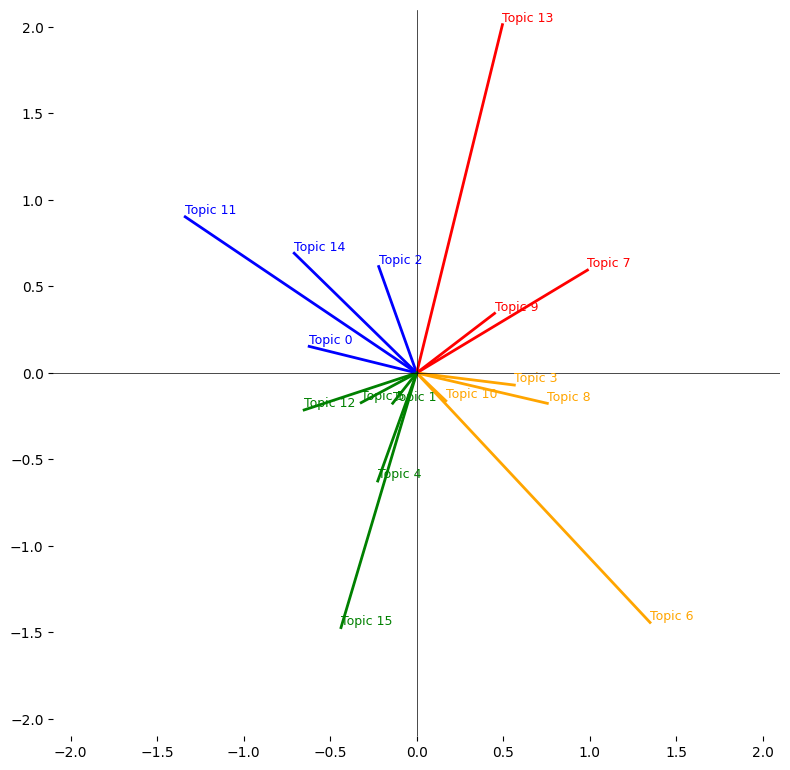

In [36]:
colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink', 'brown', 'gray']

fig, ax = plt.subplots(figsize=(8, 10))

for topic_id, row in drifts_df.iterrows():
    x, y, label_id = row['x'], row['y'], int(row['labels'])
    color = colors[label_id]
    ax.plot([0, x], [0, y], color=color, linewidth=2, label=f"Topic {topic_id}")
    ax.text(x, y, f"Topic {topic_id}", fontsize=9, color=color, ha='left', va='bottom')

lim = 2.1
ax.set_aspect('equal', 'box')
ax.set_xlim(-lim, lim); ax.set_ylim(-lim, lim)
ax.axhline(0, color='black', linewidth=0.5); ax.axvline(0, color='black', linewidth=0.5)
ax.set_frame_on(False)
fig.tight_layout()

fig.savefig(os.path.join(OUTPUTS_PATH, f"{FILES_PREFIX}_topol_drifts.pdf"), format="pdf", bbox_inches='tight')
plt.show()

### Drift explainability

In [37]:
fpath = os.path.join(DATA_PATH, "narrative_dimensions.pickle")
if os.path.exists(fpath):
    with open(fpath, "rb") as f:
        NARRATIVE_DIMENSIONS = pickle.load(f)
    print(f"Loaded {len(NARRATIVE_DIMENSIONS)} narrative dimensions from {fpath}")
else:
    raise FileNotFoundError(f"File {fpath} not found. Please generate narrative dimensions first.")
del fpath

Loaded 123 narrative dimensions from /Users/tig1/Programming/TOPOL/data/narrative_dimensions.pickle


In [38]:
fpath = os.path.join(DATA_PATH, "prompt_template.txt")
if os.path.exists(fpath):
    with open(fpath, "r") as f:
        PROMPT_TEMPLATE = f.read()
    print(f"Loaded prompt template from {fpath}")
else:
    raise FileNotFoundError(f"Prompt template file not found at {fpath}")
del fpath

Loaded prompt template from /Users/tig1/Programming/TOPOL/data/prompt_template.txt


In [39]:
def generate_narrative_comparison_prompt(text1, text2):
    prompt = PROMPT_TEMPLATE.replace("#####DIMENSIONS_LIST#####", from_list_to_string(NARRATIVE_DIMENSIONS))
    prompt = prompt.replace("#####TEXT1#####", text1)
    prompt = prompt.replace("#####TEXT2#####", text2)
    return prompt

In [40]:
# chat_completion_func = openai_chat_completion
chat_completion_func = google_chat_completion

In [41]:
# zipped_representative_docs = list(zip(
#     topol_model.dataset_A.cluster_info['Top_Representative_Docs'],
#     topol_model.dataset_B.cluster_info['Top_Representative_Docs']
# ))
# top_n_docs = 3  # Number of top documents to compare per cluster

# for i, (top_docs_A, top_docs_B) in tqdm(enumerate(zipped_representative_docs), total=len(zipped_representative_docs)):

#     # Get the representative documents for each cluster
#     if top_n_docs is not None:
#         text1 = from_list_to_string(top_docs_A[:top_n_docs])  # Take top N docs for cluster A
#         text2 = from_list_to_string(top_docs_B[:top_n_docs])  # Take top N docs for cluster B
#     else:
#         text1 = from_list_to_string(top_docs_A)
#         text2 = from_list_to_string(top_docs_B)

#     # Generate the prompt for the LLM
#     prompt = generate_narrative_comparison_prompt(text1, text2)
#     response = chat_completion_func(prompt)

#     # Dynamic response variable (you can also use a list or dict instead of naming each one)
#     var_name = f"response_row{i}"
#     globals()[var_name] = response

#     # Parse the JSON response safely
#     parsed_llm_out = safe_json_load(response)

#     # Save to file
#     with open(f"{OUTPUTS_PATH}/{FILES_PREFIX}_ND_row{i}.json", "w", encoding="utf-8") as f:
#         json.dump(parsed_llm_out, f, ensure_ascii=False, indent=2)

#     print(f"✅ Processed and saved row {i}")